<a href="https://colab.research.google.com/github/DominikSimo/Edinburgh_bikes/blob/main/Edinburgh_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edinburgh bikes

Projekt zameraný na analýzu výpožičiek kôl v Edinburgu od firmy Just Eat Cycles.

In [33]:
import numpy as np
import pandas as pd
import sqlalchemy

!pip install pymysql

In [34]:
conn_string = "mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
alchemy_conn = sqlalchemy.create_engine(conn_string)

In [35]:
query = """select * from edinburgh_bikes"""
bikes_df = pd.read_sql(query, alchemy_conn)
bikes_df.head()

,index,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,0,2018-09-15 08:52:05,2018-09-15 09:11:48,1182,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,1,2018-09-15 09:24:33,2018-09-15 09:41:09,995,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2,2018-09-15 09:48:54,2018-09-15 10:46:40,3466,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116
3,3,2018-09-16 12:01:36,2018-09-16 12:25:26,1430,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385
4,4,2018-09-16 12:03:43,2018-09-16 12:11:16,452,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646


- z informací o tabuľke obsahújucej údaje o vypožičkach kôl sa dá zistiť, že  obsahuje 14 stĺpcov a 340 986 záznamov (riadkov), pričom iba u 2374 začiatočných staníc a 2560 konečných staníc z celkového datasetu chýba popis polohy danej stanice (stĺpce : **start_station_description** a **end_station_description**) .

In [ ]:
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340986 entries, 0 to 340985
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   index                      340986 non-null  int64         
 1   started_at                 340986 non-null  datetime64[ns]
 2   ended_at                   340986 non-null  datetime64[ns]
 3   duration                   340986 non-null  int64         
 4   start_station_id           340986 non-null  int64         
 5   start_station_name         340986 non-null  object        
 6   start_station_description  338612 non-null  object        
 7   start_station_latitude     340986 non-null  float64       
 8   start_station_longitude    340986 non-null  float64       
 9   end_station_id             340986 non-null  int64         
 10  end_station_name           340986 non-null  object        
 11  end_station_description    338426 non-null  object  

- z dát v našej tabuľke sa dá vzhľadom k popisnej štatistike najlepšie popísať stĺpec "duration" čiže dĺžka vypožičania kola. Z dát sa dá zistiť, že najkratšia výpujčka kola trvala *61 sekúnd* a najdlhšia *1373043 sekúnd* čo vychádza približne na *381 hodín* čiže *16 dní*. Priemerná hodnota výpožičania trvala *2061 sekúnd* , čiže približne *34 minút* a mediánová hodnota bola *1147 sekúnd*, čiže približne *19 minút*.

In [ ]:
desc_df = bikes_df.describe().round(0)
desc_df[["duration"]]

,duration
count,340986.0
mean,2061.0
std,8704.0
min,61.0
25%,620.0
50%,1147.0
75%,2512.0
max,1373043.0


# Histogram rozdelenia hodnôt délek jazdy

Histogram rozdelenia hodnôt délek jazdy na kole, obsahuje údaje, ktoré pokŕyvajú 95 % hodnôt z našich dát. Pre toto obmedzenie som sa rozhodol kvôli tomu, aby histogram vyzeral prehľadno a zbavil som sa extrémne veľkých hodnôt. V tejto podobe histogram stačí, lebo ukazuje trend, že sú viac preferované kratšie jazdy ako dlhšie a najväčšia četnosť sa vyskytuje medzi hodnotami 5 až 15 minút.

- tabuľka s dĺžkou výpožičiek v sekundách

In [54]:
duration_df = bikes_df[["duration"]]
duration_df

,duration
0,1182
1,995
2,3466
3,1430
4,452
...,...
340981,665
340982,372
340983,275
340984,557


- transformovanie údajov zo sekúnd na minúty.

In [60]:
duration_df1 = duration_df.copy()
duration_df1[["duration_by_minutes"]] = (duration_df[["duration"]]/60).round()
duration_df1

,duration,duration_by_minutes
0,1182,20.0
1,995,17.0
2,3466,58.0
3,1430,24.0
4,452,8.0
...,...,...
340981,665,11.0
340982,372,6.0
340983,275,5.0
340984,557,9.0


- zistenie aká hodnota pokryje 95 % nášho datasetu.

In [61]:
duration_df1.duration_by_minutes.quantile(0.95)

91.0

In [33]:
import matplotlib.pyplot as plt

- vytvorenie a úprava grafu

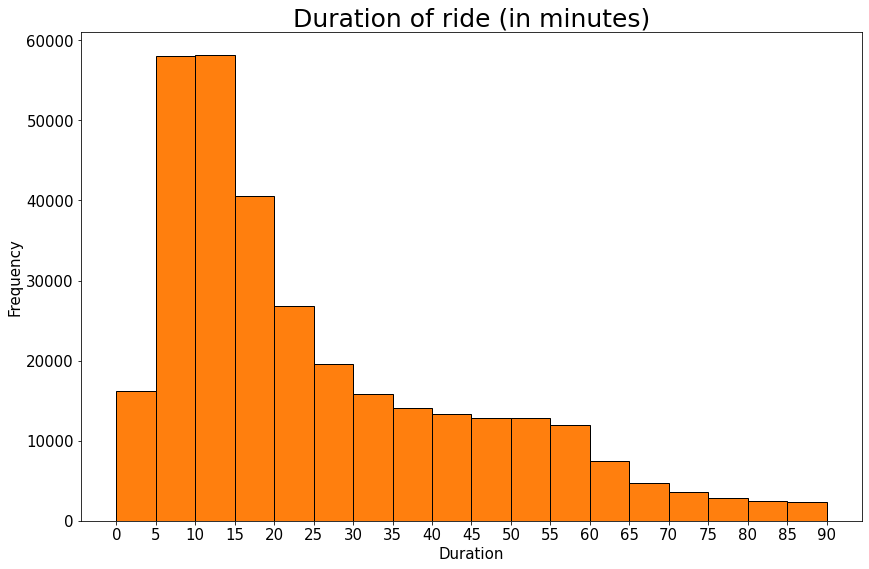

In [ ]:
duration_df1.plot.hist(by = "duration_by_minutes", range = [0,90],bins = 18, figsize = (14,9), edgecolor = "black", legend = False, fontsize = 15)
plt.xlabel("Duration", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.title("Duration of ride (in minutes)", fontsize = 25)
plt.xticks(np.arange(0,95,5))
plt.show()



# Aktívne a neaktívne stanice



Aktívne a neaktívne stanice som sa rozhodol rozdeliť podľa toho či boli aspoň jedenkrát denne využívané. Náš dataset začína od 15.9.2018 a končí 30.10.2020 čo vychádza na 777 dní, takže aby bola stanica zaradená medzi aktívne stanice musí prekročiť túto hranicu inak je zaradená medzi neaktívne stanice. Využívanosť stanice posudzujem tak, že sčítam počet kedy bola využívaná ako štartovacia stanica a kedy ako konečná stanica. Taktiež som sa rozhodol, že budem pracovať primárne s názvami staníc a nie s ich ID. Je to kvôli tomu, že niektoré stanice majú rovnaké meno ale rozdielne ID, pričom vzdialenosť medzi takýmito stanicami je malá (približne 10 m ) a nachádzajú sa prakticky vedľa seba. Využitie tohto spôsobu mi príde správne vďaka tomu, že medzi sebou môžem porovnávať "lokality", čo mi príde v prípade tejto analýzy ako výhodnejšie riešenie. 



- tabuľka využívania štartovacích staníc 

In [83]:
start_df = bikes_df.groupby(["start_station_name"]).count().sort_values(by= "index",ascending = False)[["index"]]
start_df = start_df.rename_axis("station_name",axis=0).rename(columns = {"index":"count_of_starts"})
start_df

,count_of_starts
station_name,
Meadows East,12715
Bristo Square,10999
St Andrew Square,10372
Meadow Place,8662
Victoria Quay,8140
...,...
Pleasance - Edinburgh University Sports Fair,2
Royal Highland Show - West Gate (19th to 23rd June),1
Cycling Scotland Conference,1


- tabuľka využívania konečných staníc 

In [84]:
end_df = bikes_df.groupby(["end_station_name"]).count().sort_values(by= "index",ascending = False)[["index"]]
end_df = end_df.rename_axis("station_name",axis=0).rename(columns = {"index":"count_of_ends"})
end_df

,count_of_ends
station_name,
Victoria Quay,11479
Meadows East,11371
Portobello - Kings Road,10091
Canonmills,9482
Leith Walk,9326
...,...
Depot,3
Virtual Depot,2
Cycling Scotland Conference,2


- spojená tabuľka s celkovými interakciami stanice a jej statutom či je aktívna (**Active**) alebo neaktívna (**Inactive**). Zobrazených je 10 najviac využívaných staníc.

In [85]:
joined_df = start_df.join(end_df, how= "outer").fillna(0)
joined_df["sum_of_interactions"] = joined_df["count_of_starts"] + joined_df["count_of_ends"]
joined_df["status_of_station"] = np.where(joined_df["sum_of_interactions"] > 777, "Active", "Inactive")
joined_df.sort_values("sum_of_interactions",ascending=False).head(10)

,count_of_starts,count_of_ends,sum_of_interactions,status_of_station
station_name,,,,
Meadows East,12715.0,11371.0,24086.0,Active
Victoria Quay,8140.0,11479.0,19619.0,Active
Portobello - Kings Road,8036.0,10091.0,18127.0,Active
Bristo Square,10999.0,6672.0,17671.0,Active
St Andrew Square,10372.0,6943.0,17315.0,Active
Canonmills,7589.0,9482.0,17071.0,Active
Leith Walk,6554.0,9326.0,15880.0,Active
Meadow Place,8662.0,7120.0,15782.0,Active
Dundee Terrace,6910.0,7019.0,13929.0,Active


- 10 najmenej využívaných staníc

In [86]:
joined_df.sort_values("sum_of_interactions",ascending=False).tail(10)

,count_of_starts,count_of_ends,sum_of_interactions,status_of_station
station_name,,,,
Depot Virtual,3.0,5.0,8.0,Inactive
Pleasance - Edinburgh University Sports Fair,2.0,6.0,8.0,Inactive
Sustrans - walk cycle event,4.0,3.0,7.0,Inactive
Depot,2.0,3.0,5.0,Inactive
Smarter Travel Station,0.0,3.0,3.0,Inactive
Cycling Scotland Conference,1.0,2.0,3.0,Inactive
Royal Highland Show - West Gate (19th to 23rd June),1.0,2.0,3.0,Inactive
Virtual Depot,0.0,2.0,2.0,Inactive
Picady Place,1.0,1.0,2.0,Inactive


 - celkovo dataset obsahuje podľa mojich nastavených kritérí 112 aktívnych staníc a 59 neaktívnych staníc

In [ ]:
joined_df["status_of_station"].value_counts()

Active      112
Inactive     59
Name: status_of_station, dtype: int64

Najviac frekventované a najmenej frekventované stanice som sa rozhodol určiť podľa decilového rozdelenia. Najviac frekventované stanice patria medzi 10% najpoužívanejších staníc (*Decile_rank = 9*) a najmenej frekventované medzi 10% najmenej používanych (*Decile_rank = 0*).

In [ ]:
decile_df = joined_df.copy()
decile_df["Decile_rank"]= pd.qcut(decile_df["sum_of_interactions"],q=10,labels= False)
decile_df.sort_values("Decile_rank",ascending= False)

,count_of_starts,count_of_ends,sum_of_interactions,status_of_station,Decile_rank
station_name,,,,,
Ocean Terminal,5236.0,6991.0,12227.0,Active,9
St Andrew Square,10372.0,6943.0,17315.0,Active,9
Duke Street,5617.0,7961.0,13578.0,Active,9
Fountainbridge,7081.0,6160.0,13241.0,Active,9
Leith Walk,6554.0,9326.0,15880.0,Active,9
...,...,...,...,...,...
City Chambers Launch Station,1.0,0.0,1.0,Inactive,0
Crescent House,9.0,9.0,18.0,Inactive,0
Ingliston Park and Ride (19th to 23rd June),11.0,7.0,18.0,Inactive,0


- 10% najpoužívaneješích staníc

In [ ]:
decile_df.loc[decile_df["Decile_rank"] == 9].sort_values("sum_of_interactions",ascending = False)

,count_of_starts,count_of_ends,sum_of_interactions,status_of_station,Decile_rank
station_name,,,,,
Meadows East,12715.0,11371.0,24086.0,Active,9
Victoria Quay,8140.0,11479.0,19619.0,Active,9
Portobello - Kings Road,8036.0,10091.0,18127.0,Active,9
Bristo Square,10999.0,6672.0,17671.0,Active,9
St Andrew Square,10372.0,6943.0,17315.0,Active,9
Canonmills,7589.0,9482.0,17071.0,Active,9
Leith Walk,6554.0,9326.0,15880.0,Active,9
Meadow Place,8662.0,7120.0,15782.0,Active,9
Dundee Terrace,6910.0,7019.0,13929.0,Active,9


- 10% najmenej používaných staníc 

In [ ]:
decile_df.loc[decile_df["Decile_rank"] == 0].sort_values("sum_of_interactions")

,count_of_starts,count_of_ends,sum_of_interactions,status_of_station,Decile_rank
station_name,,,,,
City Chambers Launch Station,1.0,0.0,1.0,Inactive,0
Picady Place,1.0,1.0,2.0,Inactive,0
Virtual Depot,0.0,2.0,2.0,Inactive,0
Cycling Scotland Conference,1.0,2.0,3.0,Inactive,0
Royal Highland Show - West Gate (19th to 23rd June),1.0,2.0,3.0,Inactive,0
Smarter Travel Station,0.0,3.0,3.0,Inactive,0
Depot,2.0,3.0,5.0,Inactive,0
Sustrans - walk cycle event,4.0,3.0,7.0,Inactive,0
Depot Virtual,3.0,5.0,8.0,Inactive,0


Stanice kde sa hromadia kola a kde prebývajú som sa rozhodol určiť podľa rozdielu medzi tým koľkokrát si požičali kolo v danej stanici na začiatku jazdy a koľko krát danú stanicu použili ako konečnú zastávku svojej jazdy. Stanica kde si ľudia **viac požičiavajú ako vracajú** kola bude stanica kde je **nedostatok kôl** (**shortage**) a stanice kde **viac vracajú ako si požičiavajú** budú identifikované ako stanice s **prebytkom kôl** (**surplus**).

In [ ]:
joined_df["usability"] = joined_df["count_of_starts"] - joined_df["count_of_ends"]
joined_df["status_of_usability"] = np.where(joined_df["usability"]>0,"shortage", "surplus")
joined_df

,count_of_starts,count_of_ends,sum_of_interactions,status_of_station,usability,status_of_usability
station_name,,,,,,
Abbeyhill,3360.0,3689.0,7049.0,Active,-329.0,surplus
Balgreen,80.0,101.0,181.0,Inactive,-21.0,surplus
Balgreen Road,1779.0,2100.0,3879.0,Active,-321.0,surplus
Belford Road,810.0,766.0,1576.0,Active,44.0,shortage
Boroughmuir,2870.0,2942.0,5812.0,Active,-72.0,surplus
...,...,...,...,...,...,...
Wester Coates Terrace,1937.0,2088.0,4025.0,Active,-151.0,surplus
Western General,358.0,400.0,758.0,Inactive,-42.0,surplus
Western General Hospital,1110.0,1122.0,2232.0,Active,-12.0,surplus


- z údajov som zistil, že na 96 staniciach dochádza k prebytku kôl a na 75 dochádzka k ich nedostatku.

In [ ]:
joined_df["status_of_usability"].value_counts()

surplus     96
shortage    75
Name: status_of_usability, dtype: int64

- tabuľka nižšie zobrazuje 10 staníc s najväčším množstvom interakcí.

In [ ]:
joined_df.sort_values("sum_of_interactions",ascending=False).head(10)

,count_of_starts,count_of_ends,sum_of_interactions,status_of_station,usability,status_of_usability
station_name,,,,,,
Meadows East,12715.0,11371.0,24086.0,Active,1344.0,shortage
Victoria Quay,8140.0,11479.0,19619.0,Active,-3339.0,surplus
Portobello - Kings Road,8036.0,10091.0,18127.0,Active,-2055.0,surplus
Bristo Square,10999.0,6672.0,17671.0,Active,4327.0,shortage
St Andrew Square,10372.0,6943.0,17315.0,Active,3429.0,shortage
Canonmills,7589.0,9482.0,17071.0,Active,-1893.0,surplus
Leith Walk,6554.0,9326.0,15880.0,Active,-2772.0,surplus
Meadow Place,8662.0,7120.0,15782.0,Active,1542.0,shortage
Dundee Terrace,6910.0,7019.0,13929.0,Active,-109.0,surplus


# Vzdialenosť medzi stanicami

V ďalšej časti som pripravil maticu, ktorá zaznamenáva vzdialenosti mezdi jednotlivými stanicami v kilometroch. 

In [7]:
from sklearn.neighbors import DistanceMetric
from math import radians

- tabuľka s geolokačnými údajmi každej stanice, ktorá slúžila ako štartovacia stanica.

In [14]:
query = """select distinct start_station_name,start_station_latitude,start_station_longitude from edinburgh_bikes"""
location_df_start = pd.read_sql(query, alchemy_conn)
location_df_start.head(5)

,start_station_name,start_station_latitude,start_station_longitude
0,Charlotte Square,55.952335,-3.207101
1,St Andrew Square,55.954749,-3.192774
2,Canonmills,55.962804,-3.196284
3,Kings Buildings 4,55.922001,-3.176902
4,Kings Building 2,55.923202,-3.171646


- očistenie údajov od opakujúcich sa staníc s rovnakým menom a len minimálne rozdielnymi geolokačnými údajmi

In [ ]:
df1 = location_df_start.drop_duplicates(["start_station_name"]).rename(columns = {"start_station_name":"station_name"})
df1

,station_name,start_station_latitude,start_station_longitude
0,Charlotte Square,55.952335,-3.207101
1,St Andrew Square,55.954749,-3.192774
2,Canonmills,55.962804,-3.196284
3,Kings Buildings 4,55.922001,-3.176902
4,Kings Building 2,55.923202,-3.171646
...,...,...,...
220,Leith Walk North,55.967918,-3.173586
222,Musselburgh Lidl,55.943880,-3.066754
223,Musselburgh Brunton Hall,55.944009,-3.058493
225,Picady Place,55.956535,-3.186248


- tabuľka s geolokačnými údajmi každej stanice, ktorá slúžila ako konečná stanica.

In [15]:
query = """ select distinct end_station_name,end_station_latitude, end_station_longitude from edinburgh_bikes"""
location_df_end = pd.read_sql(query,alchemy_conn)
location_df_end.head(5)

,end_station_name,end_station_latitude,end_station_longitude
0,St Andrew Square,55.954728,-3.192653
1,Canonmills,55.962804,-3.196284
2,Victoria Quay,55.977638,-3.174116
3,Kings Building 3,55.923479,-3.175385
4,Kings Building 2,55.923202,-3.171646


- očistenie údajov od opakujúcich sa staníc s rovnakým menom a len minimálne rozdielnymi geolokačnými údajmi

In [ ]:
df2 = location_df_end.drop_duplicates(["end_station_name"]).rename(columns = {"end_station_name":"station_name"})
df2

,station_name,end_station_latitude,end_station_longitude
0,St Andrew Square,55.954728,-3.192653
1,Canonmills,55.962804,-3.196284
2,Victoria Quay,55.977638,-3.174116
3,Kings Building 3,55.923479,-3.175385
4,Kings Building 2,55.923202,-3.171646
...,...,...,...
222,Leith Walk North,55.967918,-3.173586
224,Musselburgh Lidl,55.943880,-3.066754
225,Musselburgh Brunton Hall,55.944009,-3.058493
227,Picady Place,55.956535,-3.186248


- spojenie štartovacích a konečných staníc pre pokrytie čo najväčšieho vzorku, kedže nie všetky štartovacie stanie musia byť aj konečné a všetky konečné stanice štartovacie. 

In [ ]:
join_df1 = df1.merge(df2,how ="outer", on = "station_name")
join_df1.start_station_latitude.fillna(join_df1.end_station_latitude, inplace = True)
join_df1.start_station_longitude.fillna(join_df1.end_station_longitude, inplace = True)
del join_df1["end_station_latitude"]
del join_df1["end_station_longitude"]
join_df1.rename(columns={"start_station_latitude":"latitude","start_station_longitude":"longitude"},inplace= True)

- zmena jednotiek na radiány, kvôli vytvoreniu matice so vzdialenostmi staníc

In [ ]:
join_df1['latitude'] = np.radians(join_df1['latitude'])
join_df1['longitude'] = np.radians(join_df1['longitude'])
join_df1

,station_name,latitude,longitude
0,Charlotte Square,0.976552,-0.055974
1,St Andrew Square,0.976595,-0.055724
2,Canonmills,0.976735,-0.055786
3,Kings Buildings 4,0.976023,-0.055447
4,Kings Building 2,0.976044,-0.055356
...,...,...,...
166,Musselburgh Brunton Hall,0.976407,-0.053381
167,Picady Place,0.976626,-0.055611
168,Picardy Place,0.976626,-0.055611
169,Virtual Depot,0.976903,-0.055079


- výsledná matica so vzdialenosťami medzi jednotlivými stanicami v km

In [ ]:
dist = DistanceMetric.get_metric('haversine')
x = join_df1[['latitude','longitude']].to_numpy()
distance_table = pd.DataFrame(dist.pairwise(x)*6373,columns = join_df1.station_name,index = join_df1.station_name)
distance_table

station_name,Charlotte Square,St Andrew Square,Canonmills,Kings Buildings 4,Kings Building 2,Kings Buildings 1,Kings Building 3,Pollock Halls,Royal Commonwealth Pool,Meadows East,Waverley Bridge,City Chambers,Portobello,Launch Day Event,Brunswick Place,George Square,Bristo Square,Victoria Quay,Fountainbridge,Waverley Court,Lauriston Place,Waverley Station,Stockbridge,Victoria Park,St Andrews House,Depot,Shrubhill,Riego Street,"Waitrose, Comely Bank",Leith Links,Ocean Terminal,Castle Street,Bruntsfield,Royal Infirmary,Castle Terrace,Simon Square,Warrender Park Road,Thirlestane Road,Dalry Road Co-op,Whitehouse Loan,...,Dean Street,Edinburgh Royal Infirmary,IGMM - Western General,Waitrose Comely Bank,Western General Hospital,Meggetland,Haymarket Terrace,Bruntsfield Links,Balgreen Road,Ellersly Road,Chambers Street,Joppa,Gorgie Road,Royal Edinburgh Hospital,Abbeyhill,Dynamic Earth,Drumsheugh Place,Boroughmuir,Duke Street,Edinburgh Park Station,Heriot Watt - Student Accommodation,City Chambers Launch Station,Edinburgh Park Central,The Loan,Borrowman Square,Dalmeny Station,Hopetoun Road,Forth Bridge Visitors Centre,Hawes Pier,Scotstoun House,Tesco Ferrymuir,Port Edgar Marina,Ingliston Park & Ride,Leith Walk North,Musselburgh Lidl,Musselburgh Brunton Hall,Picady Place,Picardy Place,Virtual Depot,Smarter Travel Station
station_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Charlotte Square,0.000000,0.931733,1.345211,3.863207,3.921687,3.754993,3.769153,2.605202,2.543733,2.060039,0.982708,1.077792,5.641687,1.463915,1.885286,1.558371,1.346948,3.483916,1.007588,1.429097,1.040698,1.219468,0.695598,2.560725,1.585639,3.893060,2.060891,0.826117,1.292064,3.128581,3.746175,0.261024,1.688617,5.544904,0.695086,1.733537,1.653643,1.959283,1.393455,1.805389,...,0.708786,5.443424,1.923970,1.294579,2.027761,3.212100,1.212458,1.692566,3.119875,2.844701,1.248822,7.008588,2.074738,2.754328,2.196418,1.958935,0.337376,1.457359,3.090704,6.839314,9.019776,1.074228,7.087303,12.582433,11.363988,11.565922,12.994373,12.858943,11.894951,12.079662,12.587401,13.246436,9.368654,2.712682,8.791613,9.301911,1.380064,1.380064,3.896884,284.735293
St Andrew Square,0.931733,0.000000,0.922255,3.774368,3.747654,3.598554,3.642950,2.108575,2.108773,1.775354,0.387929,0.539309,4.732043,1.359494,1.004801,1.326903,1.005750,2.798382,1.630421,0.631594,1.144480,0.402145,1.042822,2.171405,0.712821,3.021958,1.198497,1.264437,1.980716,2.276249,3.123748,0.742163,2.133575,5.010404,1.058865,1.266436,1.851769,2.187117,2.230985,2.132925,...,1.368751,4.998922,2.590502,1.982051,2.680055,3.952013,2.117183,2.137109,4.036535,3.776429,0.830547,6.139958,2.918908,3.257171,1.281339,1.137072,1.268853,2.154061,2.239096,7.764667,9.918764,0.527071,8.018183,13.345437,12.147120,12.330466,13.761450,13.635571,12.644537,12.877737,13.378810,14.003841,10.293020,1.890190,7.941127,8.447966,0.452358,0.452358,3.025882,284.959808
Canonmills,1.345211,0.922255,0.000000,4.696374,4.664602,4.517496,4.563753,2.969880,2.991564,2.693197,1.310128,1.461039,4.985350,2.273307,0.973808,2.248943,1.927927,2.150913,2.308850,1.443664,2.006677,1.255062,0.872246,1.277740,1.405796,2.733796,1.047051,2.015861,1.729453,1.963541,2.401109,1.328662,2.921757,5.799665,1.819493,2.167688,2.720749,3.055654,2.728677,2.968514,...,1.278326,5.836141,2.218480,1.729085,2.281399,4.557171,2.497978,2.925563,4.324788,3.932102,1.752166,6.508967,3.398383,4.033363,1.718151,1.826660,1.598778,2.793093,1.926432,7.966285,10.234605,1.448701,8.155818,12.897166,11.734157,11.887972,13.318011,13.207192,12.179083,12.486858,12.975049,13.545349,10.272484,1.523210,8.336440,8.831782,0.936310,0.936310,2.737282,285.865167
Kings Buildings 4,3.863207,3.774368,4.696374,0.000000,0.353751,0.309310,0.189646,2.025247,1.899923,2.013961,3.386902,3.235334,5.397788,2.457412,4.337591,2.450460,2.768661,6.190917,3.115187,3.338193,2.832824,3.471789,4.506788,5.913601,3.479078,5.754528,4.511700,3.069034,5.079522,5.286739,6.594366,3.667118,2.495859,2.716

# Vývoj poptávky výpožičiek kôl v čase

Na zobrazenie poptávky po kolách v čase som využil líniový graf. Na grafe je na prvý pohľad vidieť, že väčší počet vypožičaných kôl bol v roku 2020 ako v roku 2019. V datasete sa nachádza presne 22 dní kedy neni zaznamenaná žiadna výpujčka kola. Tieto dni sú vždy posledné dni v mesiaci a pravidelne sa tieto dni začali objavovať každý mesiac od května 2020. Pripisujem to k tomu, že v tieto dni prebiehala pravidelná mesačná kontrola alebo inventarizácia.

- tabuľka s počtom výpožičiek v jednotlivé dni 

In [36]:
bikes_time_df = bikes_df.groupby(pd.Grouper(key="started_at", freq = "D")).count()[["index"]].rename(columns = {"index":"number_of_rentals"}).rename_axis("date")
bikes_time_df

,number_of_rentals
date,
2018-09-15,3
2018-09-16,10
2018-09-17,403
2018-09-18,126
2018-09-19,77
...,...
2020-10-26,560
2020-10-27,437
2020-10-28,559


- tvorba a úprava grafu

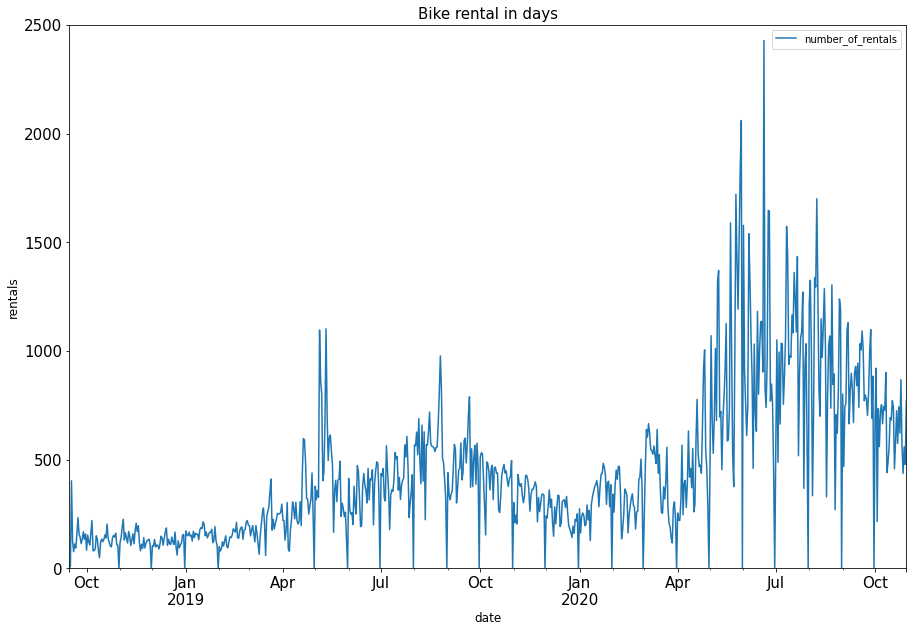

In [ ]:
bikes_time_df.plot.line(figsize = (15,10), fontsize= 15)
plt.title("Bike rental in days",fontsize = 15)
plt.xlabel("date",fontsize = 12)
plt.ylabel("rentals",fontsize = 12)
plt.ylim(0,2500)
plt.show()

- ukážka dní kedy nebolo vypožičané ani jedno kolo. Týka sa to posledních dní v mesiaci.

In [ ]:
bikes_time_df.loc[bikes_time_df["number_of_rentals"] == 0]

,number_of_rentals
date,
2018-10-31,0
2018-11-30,0
2018-12-31,0
2019-01-31,0
2019-04-30,0
2019-05-31,0
2019-06-30,0
2019-07-31,0
2019-08-31,0


Pre lepšiu analýzu potávky som sa rozhodol spraviť ešte stloupcový graf, na ktorom je lepšie vidieť nárast počtu výpožičiek kôl v roku 2020, konkrétne od května 2020. Ako dôvod nárastu od tohto data vidím prepuknutie pandémie COVID-19, ktorá nútila ľudí viac využívať individuálne prepravné prostriedky (kola) voči hromadným prepravným prostriedkom. Na grafoch je taktiež vidieť, že v jarných a letných mesiacoch dochádza k rastu pôžičiek kôl oproti mesiacom v zime a na podzim.

- vytvorenie tabuľky, kde sú združené výpujčky podľa mesiaca.

In [68]:
bikes_time_df1 = bikes_df.groupby(pd.Grouper(key="started_at", freq = "M")).count()[["index"]].rename(columns = {"index":"number_of_rentals"}).rename_axis("date")
bikes_time_df1.head(5)

,number_of_rentals
date,
2018-09-30,2226
2018-10-31,3799
2018-11-30,4047
2018-12-31,3662
2019-01-31,4750


- úprava stĺpcového grafu a vytvorenie funkcie na prehladnejšie zobrazenie mesiacov v grafe.






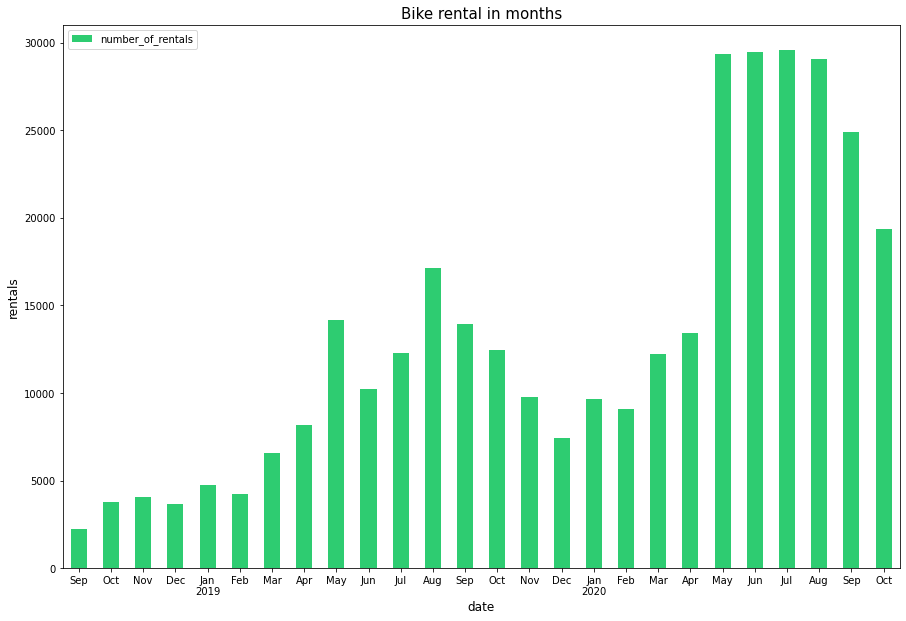

In [ ]:
def line_format(label):
    month = label.month_name()[:3]
    if month == "Jan":
        month += f"\n{label.year}"
    return month

ax = bikes_time_df1.plot(kind="bar", figsize=(15, 10), color="#2ecc71", rot=0)
ax.set_xticklabels(map(line_format, bikes_time_df1.index))
ax.set_xlabel("date",fontsize = 12)
ax.set_ylabel("rentals", fontsize = 12)
ax.set_title("Bike rental in months", fontsize = 15)
ax.legend(loc="upper left");

# Víkend/pracovný týždeň

Následná časť analýzy je venovaná otázke či má víkend vplyv na množstvo výpožičiek. Z výsledných údajov je vidieť, že využitie kôl v pracovný den (od pondelka do piatka) je v priemere nižšie o 53 výpožičiek ako cez víkend. Výpožičiek kôl cez týždeň je v priemere 423 na deň a cez víkend 476 na deň.

- vytvorenie tabuľky so stĺpcom WEEKDAY, ktorá určuje či je deň v týždni počas pracovného týždňa ( pondelok - piatok ) alebo počas víkendu ( sobota - nedeľa )

In [37]:
bikes_time_df['WEEKDAY'] = np.where((bikes_time_df.index.dayofweek) < 5,"weekday","weekend")
bikes_time_df

,number_of_rentals,WEEKDAY
date,,
2018-09-15,3,weekend
2018-09-16,10,weekend
2018-09-17,403,weekday
2018-09-18,126,weekday
2018-09-19,77,weekday
...,...,...
2020-10-26,560,weekday
2020-10-27,437,weekday
2020-10-28,559,weekday


- zistenie celkového počtu výpožičiek cez víkend a cez týždeň

In [71]:
bikes_week_df = bikes_time_df.groupby("WEEKDAY").sum()
bikes_week_df

,number_of_rentals
WEEKDAY,
weekday,235188
weekend,105798


- počet dní v týdnu a počet dní cez víkend v našom datasete

In [72]:
bikes_time_df["WEEKDAY"].value_counts()

weekday    555
weekend    222
Name: WEEKDAY, dtype: int64

- priemerný počet výpožičiek na deň cez víkend a na deň v pracovnom týždni

In [77]:
bikes_week_df["avg_rental_per_day"] = [235188//555 if x =='weekday' else 105798//222 for x in bikes_week_df.index]
bikes_week_df 

,number_of_rentals,avg_rental_per_day
WEEKDAY,,
weekday,235188,423
weekend,105798,476


# Vplyv počasia na výpožičku kôl

Posledná časť analýzy je venovaná vplyvu počasia na požičiavanie kôl. Rozhodol som sa zamerať na dve premenné z tabuľky počasia a konkrétne na premennú teplota (**temp**) a dážď (**rain**). 

In [7]:
query = """select * from edinburgh_weather"""
weather_df = pd.read_sql(query, alchemy_conn)
weather_df.head(5)

,time,temp,feels,wind,gust,rain,humidity,cloud,pressure,vis,date
0,00:00,11 °c,11 °c,9 km/h from S,19 km/h,0.0 mm,79%,13%,1020 mb,Excellent,2018-09-01
1,03:00,13 °c,12 °c,11 km/h from SSW,19 km/h,0.0 mm,76%,96%,1020 mb,Excellent,2018-09-01
2,06:00,14 °c,13 °c,11 km/h from SSW,19 km/h,0.0 mm,84%,100%,1020 mb,Excellent,2018-09-01
3,09:00,14 °c,13 °c,14 km/h from SSW,23 km/h,0.1 mm,88%,78%,1021 mb,Excellent,2018-09-01
4,12:00,16 °c,16 °c,15 km/h from SSW,22 km/h,0.0 mm,87%,87%,1021 mb,Excellent,2018-09-01


- kópia tabuľky, kvoli zmene dátoveho typu určitých premenných

In [8]:
weather_df1 = weather_df.copy()

- zmena a úprava typu premenných na číselne hodnoty 

In [9]:
weather_df1["temp"] = weather_df1["temp"].str.replace("°c"," ")
weather_df1["temp"] = pd.to_numeric(weather_df1["temp"])

- priemerná denná teplota v jendotlivé dni 

In [13]:
temp_df= weather_df1.groupby(["date"]).mean()
temp_df 

,temp
date,
2018-09-01,14.375
2018-09-02,16.500
2018-09-03,11.875
2018-09-04,11.250
2018-09-05,12.500
...,...
2020-10-27,7.125
2020-10-28,7.250
2020-10-29,6.750


Tabuľka, kde je vidieť 20 dní s najväčším počtom výpožičiek kôl a priemernej dennej teploty. Je vidieť, že teplota sa pohybuje v rozmezí 11 °C až 19 °C. Tieto údaje spolu s údajmi o najmenšom počte výpožičiek môžu naznačovať, že sa tu vyskytuje korelácia medzi vyššou teplotou a väčším počtom výpožičiek kôl.

In [49]:
join_df2 = bikes_time_df.join(temp_df,how = "left")
join_df2 = join_df2.drop(columns = "WEEKDAY")
join_df2.sort_values(by = "number_of_rentals", ascending= False).head(20)

,number_of_rentals,temp
date,,
2020-06-20,2428,15.375
2020-05-30,2060,16.500
2020-05-29,1832,18.875
2020-05-25,1721,13.000
2020-08-08,1700,14.250
2020-06-24,1646,17.250
2020-06-25,1644,18.500
2020-05-20,1589,15.500
2020-06-01,1578,15.875


V následnej tabuľke som si zobrazil 20 dní s najmenším počtom výpožičiek. Priemerná denná teplota sa pohybuje od 1 °C do 14 °C. V porovnaní s predchádzajúcou tabuľkou je vidieť, že teploty sú nižšie a majú väčší rozptyl. Takéto porovnanie môže byť ale skreslujúce pretože môže byť ovplyvnené menšou dostupnosťou kôl v roku 2018 ako v rokoch 2019 a 2020 a teda aj väčším zastúpením dní z roku 2018 v tabuľke sa najnižším počtom výpožičiek. Preto som sa rozhodol ešte spraviť líniový graf na porovnanie.

In [30]:
join_df2.loc[join_df2["number_of_rentals"]>0].sort_values("number_of_rentals",ascending = True).head(20)

,number_of_rentals,temp
date,,
2018-09-15,3,10.500
2018-09-16,10,12.875
2018-10-13,49,12.250
2019-03-16,59,4.000
2018-12-24,61,1.875
2019-03-10,65,3.250
2018-09-19,77,11.750
2019-04-07,79,6.625
2019-02-02,80,0.875


- tabuľka s najteplejšími dňami v datasete

In [50]:
join_df2.sort_values(by = "temp", ascending= False).head(20)

,number_of_rentals,temp
date,,
2019-07-25,607,21.125
2019-07-26,469,19.625
2019-07-24,512,19.250
2020-05-29,1832,18.875
2020-07-31,0,18.500
2019-07-22,415,18.500
2020-06-25,1644,18.500
2019-08-25,977,18.000
2019-07-23,568,18.000


V líniovom grafu s dvomi líniami je pekne viditeľný trend kde vyššie teploty (**červená línia**) korelujú s vyššími hodnotami výpožičiek kôl (**modrá línia**). Tento trend je najlepšie viditelný od roku 2020.

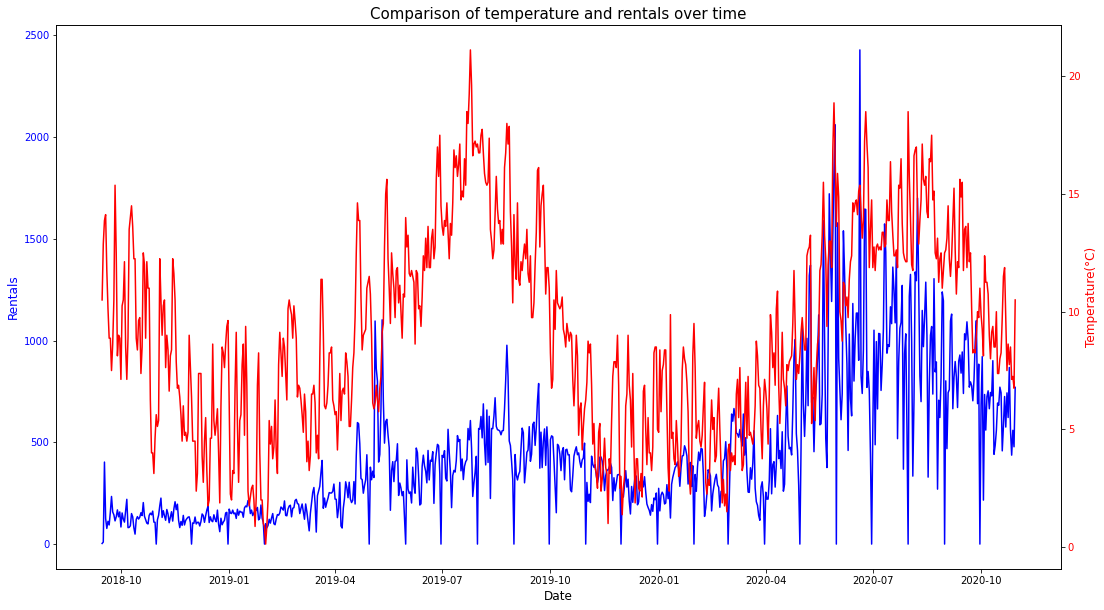

In [54]:
fig,ax = plt.subplots(figsize=(18,10))

ax.plot(join_df2["number_of_rentals"],color = "blue")
ax.tick_params(axis='y', labelcolor='blue')
ax.set_ylabel("Rentals",size = 12, color = "blue")
ax.set_xlabel("Date",size = 12)
ax.set_title("Comparison of temperature and rentals over time", size = 15)
ax2= ax.twinx()

ax2.plot(join_df2["temp"], color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel("Temperature(°C)",size =  12, color = "red")

plt.show()


U premennej ktorá zaznamenáva množstvo zrážok (**rain**) postupujem rovnako ako u premennej zaznamenávajúcej teploty (**temp**).

In [19]:
weather_df1["rain"] = weather_df1["rain"].str.replace("mm"," ")
weather_df1["rain"] = pd.to_numeric(weather_df1["rain"])

In [27]:
rain_df = weather_df1.groupby(["date"]).sum()
rain_df = rain_df.drop(columns ="temp")
rain_df

,rain
date,
2018-09-01,0.1
2018-09-02,0.4
2018-09-03,0.3
2018-09-04,0.0
2018-09-05,0.4
...,...
2020-10-27,1.0
2020-10-28,1.2
2020-10-29,10.1


Následujúce dve tabuľky znova obsahujú údaje o 20 dňoch s najväčšími výpožičkami a 20 s najmenšími výpožičkami kôl. Z tabuliek nie je možné určiť koreláciu pretože v obidvoch tabuľkách sa nachádzajú či už 0 hodnoty, ale aj vyššie hodnoty. Môže to byť spôsobené tým, že mám agregované hodnoty za jednotlivé dni, čo spôsobuje skreslenie výsledkov. 

In [ ]:
join_df3 = bikes_time_df.join(rain_df,how = "left")

In [43]:
join_df3.sort_values(by = "number_of_rentals", ascending= False).head(20)

,number_of_rentals,rain
date,,
2020-06-20,2428,6.3
2020-05-30,2060,0.0
2020-05-29,1832,0.0
2020-05-25,1721,0.0
2020-08-08,1700,0.2
2020-06-24,1646,0.4
2020-06-25,1644,0.6
2020-05-20,1589,0.0
2020-06-01,1578,0.0


In [65]:
join_df3.loc[join_df3["number_of_rentals"]>0].sort_values("number_of_rentals",ascending = True).head(20)

,number_of_rentals,rain
date,,
2018-09-15,3,1.0
2018-09-16,10,1.0
2018-10-13,49,13.6
2019-03-16,59,18.6
2018-12-24,61,0.0
2019-03-10,65,3.8
2018-09-19,77,2.9
2019-04-07,79,1.6
2019-02-02,80,0.0


- tabuľka dní s najväčšími zrážkami

In [46]:
join_df3.sort_values(by = "rain", ascending= False).head(20)

,number_of_rentals,rain
date,,
2020-10-03,216,51.8
2020-10-04,735,38.1
2020-08-04,334,37.6
2019-08-11,224,36.4
2020-08-25,270,34.7
2019-05-26,300,34.2
2019-06-24,200,32.7
2020-07-23,898,30.8
2020-02-15,163,29.8


V líniovom grafe s dvomi líniami je vidieť určitý trend, hlavne pri vyšších(extrémnych hodnotách) zrážok. Tam kde sa objaví takýto veľký výkyv je vidieť, že počet výpožičiek bol nižší ako iné dni. 

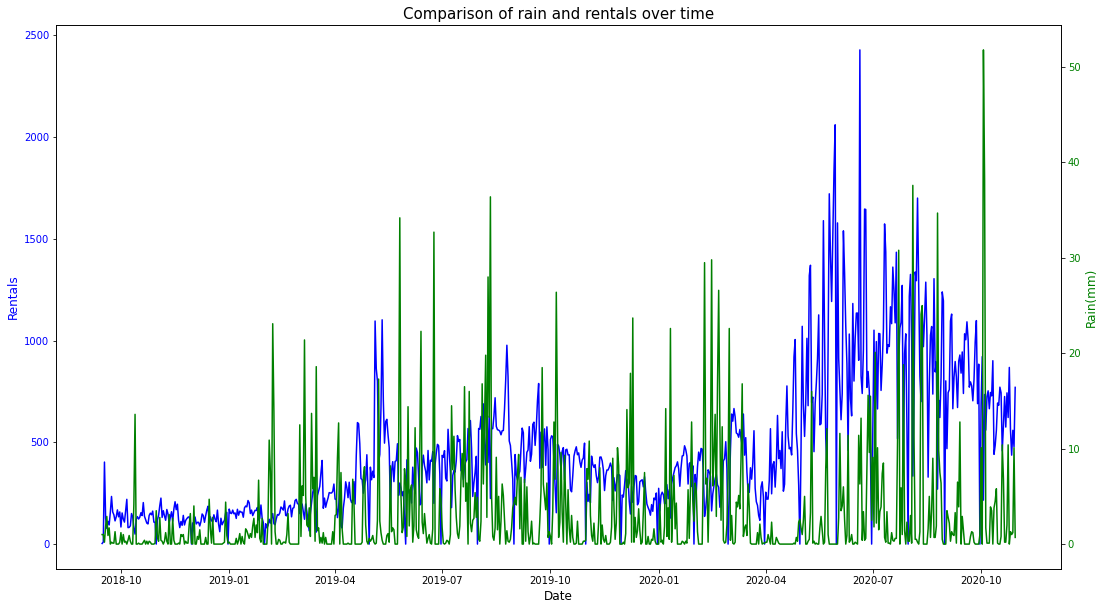

In [66]:
fig,ax = plt.subplots(figsize=(18,10))

ax.plot(join_df3["number_of_rentals"],color = "blue")
ax.tick_params(axis='y', labelcolor='blue')
ax.set_ylabel("Rentals",size = 12, color = "blue")
ax.set_xlabel("Date",size = 12)
ax.set_title("Comparison of rain and rentals over time", size = 15)
ax2= ax.twinx()

ax2.plot(join_df3["rain"], color='green')
ax2.tick_params(axis='y', labelcolor='green',)
ax2.set_ylabel("Rain(mm)",size =  12, color = "green")

plt.show()